# <font  color = "#0093AF">Solid Effect</font>

<a href="https://githubtocolab.com/alsinmr/SLEEPY_tutorial/blob/main/ColabNotebooks/Chapter4/Ch4_SolidEffect.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

The solid effect$^1$ is a two-spin mechanism of transfering polarization from electrons to nuclei. It is active when the electron is irradiated with an offset equal to the nuclear Larmor frequency:

$$
\begin{equation}
\omega_{rf}=\omega_{0e}\pm\omega_{0H}
\end{equation}
$$

In this notebook, we simulate solid effect, and observe how it depends on magic angle spinning, and how it is influenced by the electron and nuclear $T_1$s

[1] C.D. Jeffries [*Phys. Rev.*](https://doi.org/10.1103/PhysRev.106.164), **1957**, 106, 164-165.

## Setup

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt

## Build spin system
The solid effect relies on terms in the Hamiltonian that tilt the nuclear spin away from the z-axis. That is, the nucleus must be treated in the lab frame. On the other hand, we need to irradiate the electron, so we would rather leave it in the rotating frame. Then, we set the frames for the spins individually.

In [3]:
ex=sl.ExpSys(v0H=211,Nucs=['e-','1H'],LF=[False,True],vr=5000,T_K=80,pwdavg=2)
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-100000,Ayy=-100000,Azz=200000)
_=ex.set_inter('g',i=0,gxx=2.0027,gyy=2.0031,gzz=2.0034,euler=[0,0,0])

We add some relaxation to make the simulation more realistic. Values for the glycerol water with 40 mM trityl radical taken from Smith et al.$^2$

Note that because the nucleus is titled, to be fully rigorous, we need to use relaxation in the eigenbasis of the Hamiltonian, obtained by setting `OS=True` (and `Thermal=True` for $T_1$ relaxation).

[2] A.A. Smith, B. Corzilius, A.B. Barnes, T. Maly, R.G. Griffin. [*J. Chem. Phys.*](https://doi.org/10.1063/1.3670019), **2012**, 136, 015101.

In [4]:
L=ex.Liouvillian()
L.add_relax(Type='T2',i=0,T2=.890e-6,OS=True)
L.add_relax(Type='T2',i=1,T2=5e-3,OS=True)
L.add_relax(Type='T1',i=0,T1=1.4e-3,OS=True,Thermal=True)
_=L.add_relax(Type='T1',i=1,T1=13.7,OS=True,Thermal=True)

Note that SLEEPY's "on-resonance" electron has a g-value of 2.0023193 (`sl.Constants['ge']`). That means that the trityl g-tensor used here is fairly far away from being on-resonant already, such that we need to offset the applied microwave frequency by the difference between these, plus or minus the $^1$H Larmor frequency.

While we do not use this approach here, the electron g-value can be reset by the user (`sl.Constants['ge']=...`), which changes the definition of the offsets (see [Cross Effect](Ch4_CrossEffect.ipynb) for example).

In [5]:
Dele=(2.0031-sl.Constants['ge'])*sl.Constants['mub']*ex.B0  #Offset from 'ge'
vH=ex.v0[1] #Nuclear Larmor frequency
voff=Dele+vH #Applied frequency (can also be -vH)
print(f'The offset is {voff/1e6}')

The offset is 156.8503306522459


In [6]:
seq=L.Sequence()
_=seq.add_channel(channel='e-',v1=1e6,voff=voff)

In [7]:
rho=sl.Rho(rho0='Thermal',detect='1Hz')

In [8]:
rho.clear()
U=seq.U()**100  #100 rotor periods per step
_=rho.DetProp(U,n=3000)

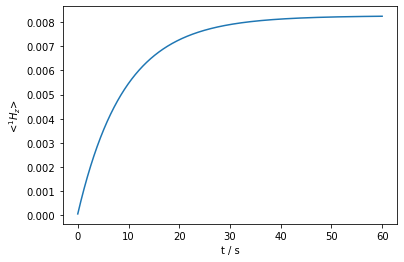

In [9]:
ax=rho.plot(axis='s')

We find the $^1$H magnetization grows considerably compared to its thermal value. To get the enhancement, we compare the final value for the $^1$H magnetization in `rho.I[0][-1]` to the thermal equilibrium stored in `ex.Peq[1]`.

In [10]:
print(f'Enhancement: {rho.I[0][-1].real/ex.Peq[1]:.0f}')

Enhancement: 130


## Behavior during a rotor period
It is interesting to note that the efficiency of DNP under MAS comes in large part because the rotor spinning sweeps us through the matching conditions for many different orientations of the electron g-tensor. Here, we select just one crystallite from our powder average, and simulate one rotor period with 100 steps, to observe the time dependence of the enhancement throughout the rotor period.

Note that we simply edit the powder average in `ex` to get the single crystal.

Prop: 100 steps per every 1 rotor period


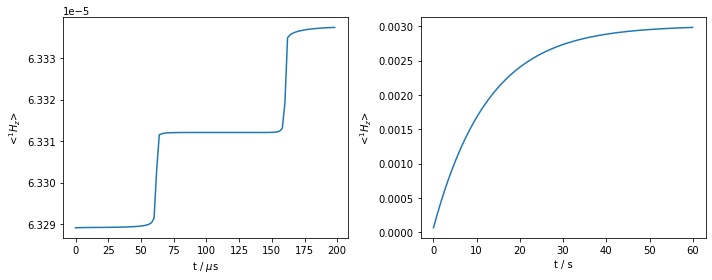

In [11]:
ex.pwdavg=sl.PowderAvg(2)[10]

rho=sl.Rho('Thermal','1Hz')

fig,ax=plt.subplots(1,2,figsize=[10,4])
rho.DetProp(seq,n=100,n_per_seq=100)
rho.plot(ax=ax[0],axis='us')
rho.clear()
U=seq.U()**100
rho.DetProp(U,n=3000)
rho.plot(ax=ax[1],axis='s')
fig.tight_layout()

We see that the solid-effect condition is hit twice per rotor period (left plot), leading to a gradual build up of the polarization (right plot). Note that the choice of index on the powder average (e.g. `sl.PowderAvg(q=2)[25]`) will change the locations in the rotor period that transfer occurs.

## Dependence on relaxation times
We re-run the first simulation, now with several different electron $T_1$s and several nuclear $T_1$s. We first need to reset the powder average.

In [12]:
ex.pwdavg=2

### Sweep electron $T_1$

Note that if you set the electron $T_1$ shorter than half the electron $T_2$, this calculation may diverge.

In [15]:
T1e0=[1,1e-1,1e-2,1e-3,1e-4,1e-5]

rho=[]

for T1e in T1e0:
    L.clear_relax()
    L.add_relax(Type='T2',i=0,T2=.890e-6,OS=True)
    L.add_relax(Type='T2',i=1,T2=5e-3,OS=True)
    L.add_relax(Type='T1',i=0,T1=T1e,OS=True,Thermal=True)
    L.add_relax(Type='T1',i=1,T1=13.7,OS=True,Thermal=True)
    
    U=seq.U()**100  #100 rotor periods per step
    rho.append(sl.Rho('Thermal','1Hz').DetProp(U,n=3000))

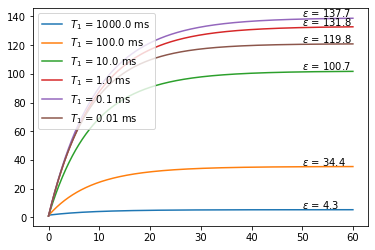

In [16]:
ax=plt.subplots()[1]
for rho0 in rho:
    e=rho0.I.max().real/ex.Peq[1]
    ax.plot(rho0.t_axis,rho0.I[0].real/ex.Peq[1])
    ax.text(50,e+1,fr'$\epsilon$ = {e-1:.1f}')
_=ax.legend([fr'$T_1$ = {T1e*1e3} ms' for T1e in T1e0],loc='upper left')

We see that a shorter electron $T_1$ yields a larger enhancement, since the electron must recover its magnetization when transferred to the nucleus. If it becomes too short, it interferes with the transfer itself.

### Sweep nuclear $T_1$

In [17]:
T1n0=[1,10,100]

rho=[]

for T1n in T1n0:
    L.clear_relax()
    L.add_relax(Type='T2',i=0,T2=.890e-6,OS=True)
    L.add_relax(Type='T2',i=1,T2=5e-3,OS=True)
    L.add_relax(Type='T1',i=0,T1=1.4e-3,OS=True,Thermal=True)
    L.add_relax(Type='T1',i=1,T1=T1n,OS=True,Thermal=True)
    
    U=seq.U()**100  #100 rotor periods per step
    rho.append(sl.Rho('Thermal','1Hz').DetProp(U,n=3000))

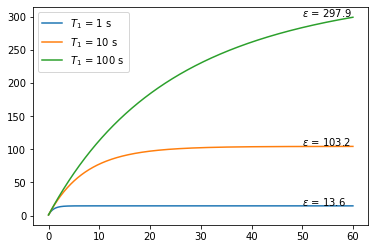

In [18]:
ax=plt.subplots()[1]
for rho0 in rho:
    e=rho0.I.max().real/ex.Peq[1]
    ax.plot(rho0.t_axis,rho0.I[0].real/ex.Peq[1])
    ax.text(50,e+1,fr'$\epsilon$ = {e-1:.1f}')
_=ax.legend([fr'$T_1$ = {T1n} s' for T1n in T1n0],loc='upper left')

In contrast to the electron, increasing the nuclear $T_1$ increases the DNP enhancement.

## Simulating solid effect without relaxation

In the last simulation, we show that relaxation is critical in achieving polarization buildup. We change the powder average back to a single orientation, and remove all relaxation via `L.clear_relax()`. What we observe is that although the solid-effect conditions are met during the rotor period, over the course of many rotor periods, the magnetization gained by the nucleus is periodically transferred back to the electron so that no net magnetization is achieved.

Prop: 100 steps per every 1 rotor period


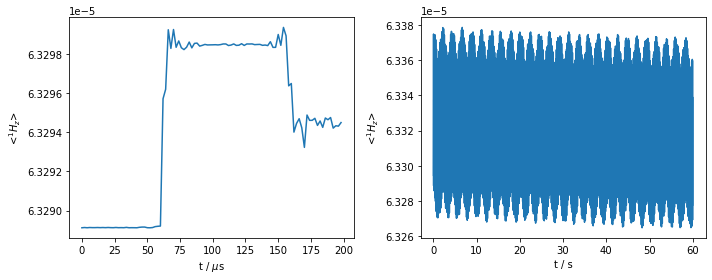

In [19]:
ex.pwdavg=sl.PowderAvg(2)[10]
L.clear_relax()

rho=sl.Rho('Thermal','1Hz')

fig,ax=plt.subplots(1,2,figsize=[10,4])
rho.DetProp(seq,n=100,n_per_seq=100)
rho.plot(ax=ax[0],axis='us')
rho.clear()
U=seq.U()**100
rho.DetProp(U,n=3000)
rho.plot(ax=ax[1],axis='s')
fig.tight_layout()